# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

# 2. Weekly graph question

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

In [3]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

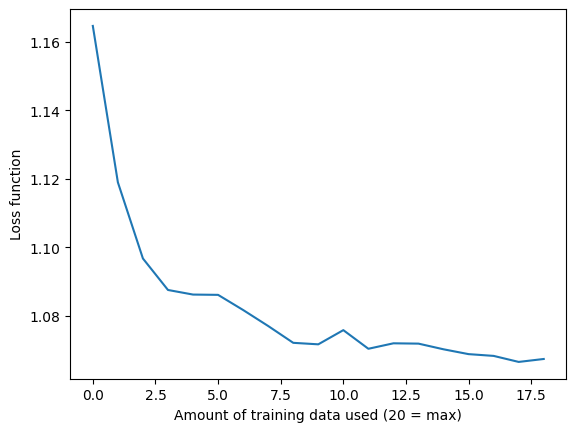

In [4]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [5]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

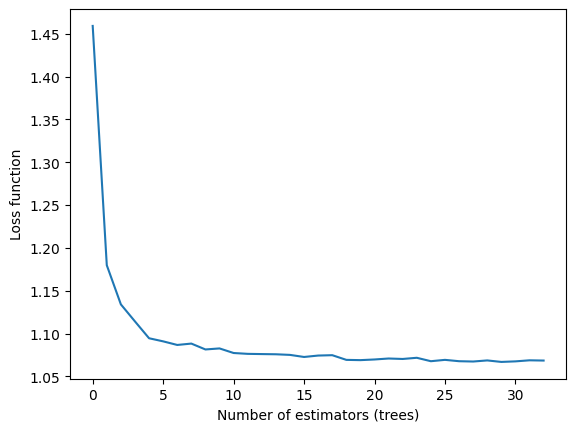

In [6]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

 I would recommend cutting the top plot and keeping the bottom plot.
 
 It's more interpretable, generalizable, and actionable.

"Amount of training data used (20 = max)" is not a standard or intuitive metric.

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your own datasets that you found last semester.

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

In [7]:
def replace_values_in_column(df, column_name, to_replace, replacement):
    df_copy = df.copy()
    
    if to_replace is np.nan or pd.isna(to_replace):
        df_copy[column_name] = df_copy[column_name].fillna(replacement)
    else:
        df_copy[column_name] = df_copy[column_name].replace(to_replace, replacement)
        
    return df_copy

# df_cleaned = replace_values_in_column(df, 'Gender', '?', 'Unknown')
# df_cleaned = replace_values_in_column(df, 'authorities_contacted', np.nan, 'Unknown')

def drop_features(dataframe, columns_to_drop):
    initial_columns = dataframe.shape[1]
    # Drop each column gradually, using try-except to avoid errors if the column is missing
    for col in columns_to_drop:
        try:
            dataframe = dataframe.drop(columns=[col])
            print(f"Dropped column: {col}")
        except KeyError:
            print(f"Column {col} not found. Skipping.")
    final_columns = dataframe.shape[1]
    print(f"Number of columns to be dropped: {len(columns_to_drop)}")
    print(f"Number of columns before dropping: {initial_columns}")
    print(f"Number of columns after dropping: {final_columns}")
    return dataframe

def categorize_hour(hour):
    if 0 <= hour <= 5:
        return 'Night'
    elif 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour <= 21:
        return 'Evening'
    elif 22 <= hour <= 23:
        return 'Late Night'
    else:
        return 'Unknown'


In [8]:
# URL of the ZIP file
df = pd.read_csv("data//auto//insurance_claims.csv")
print("First few rows of the dataset:")

dataset = df.copy()
# Delete control column: _c39
dataset.drop('_c39', axis=1, inplace=True)
# add target feature as integer
dataset['fraud_reported_int'] = dataset['fraud_reported'].map({'Y': 1, 'N': 0})
# dataset.drop('fraud_reported')

dataset['incident_date'] = pd.to_datetime(dataset['incident_date'])
dataset['policy_bind_date'] = pd.to_datetime(dataset['policy_bind_date'])

dataset['days_between_bind_and_incident'] = (dataset['incident_date'] - dataset['policy_bind_date']).dt.days

dataset['incident_year'] = dataset['incident_date'].dt.year
dataset['auto_age'] = dataset['incident_year'] - dataset['auto_year']


dataset['has_umbrella'] = dataset['umbrella_limit'].apply(lambda x: 1 if pd.to_numeric(x, errors='coerce') > 0 else 0)

dataset['incident_hour_category'] = dataset['incident_hour_of_the_day'].apply(categorize_hour)


columns_to_drop = ['fraud_reported','policy_number','policy_bind_date','insured_zip','insured_hobbies','incident_date','incident_year','auto_year','umbrella_limit','incident_location','incident_hour_of_the_day']
columns_to_drop = columns_to_drop + ['auto_model','insured_occupation']



dataset = drop_features(dataset, columns_to_drop)



First few rows of the dataset:
Dropped column: fraud_reported
Dropped column: policy_number
Dropped column: policy_bind_date
Dropped column: insured_zip
Dropped column: insured_hobbies
Dropped column: incident_date
Dropped column: incident_year
Dropped column: auto_year
Dropped column: umbrella_limit
Dropped column: incident_location
Dropped column: incident_hour_of_the_day
Dropped column: auto_model
Dropped column: insured_occupation
Number of columns to be dropped: 13
Number of columns before dropping: 45
Number of columns after dropping: 32


In [9]:
dataset = replace_values_in_column(dataset, 'collision_type', '?', 'Unknown')
dataset = replace_values_in_column(dataset, 'property_damage', '?', 'Unknown')
dataset = replace_values_in_column(dataset, 'police_report_available', '?', 'Unknown')
dataset = replace_values_in_column(dataset, 'authorities_contacted', np.nan, 'Unknown')

In [10]:
threshold = 150
value_counts = dataset['incident_type'].value_counts()
to_replace = value_counts[value_counts < threshold].index

dataset['incident_type_grouped'] = dataset['incident_type'].replace(to_replace, 'Other')

In [11]:
# Summarize the datasets using info()
dataset.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   months_as_customer              1000 non-null   int64  
 1   age                             1000 non-null   int64  
 2   policy_state                    1000 non-null   object 
 3   policy_csl                      1000 non-null   object 
 4   policy_deductable               1000 non-null   int64  
 5   policy_annual_premium           1000 non-null   float64
 6   insured_sex                     1000 non-null   object 
 7   insured_education_level         1000 non-null   object 
 8   insured_relationship            1000 non-null   object 
 9   capital-gains                   1000 non-null   int64  
 10  capital-loss                    1000 non-null   int64  
 11  incident_type                   1000 non-null   object 
 12  collision_type                  100

In [12]:
# Summarize the datasets using describe()
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
months_as_customer,1000.0,203.95400,115.113174,0.00,115.7500,199.5,276.250,479.00
age,1000.0,38.94800,9.140287,19.00,32.0000,38.0,44.000,64.00
policy_deductable,1000.0,1136.00000,611.864673,500.00,500.0000,1000.0,2000.000,2000.00
policy_annual_premium,1000.0,1256.40615,244.167395,433.33,1089.6075,1257.2,1415.695,2047.59
capital-gains,1000.0,25126.10000,27872.187708,0.00,0.0000,0.0,51025.000,100500.00
capital-loss,1000.0,-26793.70000,28104.096686,-111100.00,-51500.0000,-23250.0,0.000,0.00
number_of_vehicles_involved,1000.0,1.83900,1.018880,1.00,1.0000,1.0,3.000,4.00
bodily_injuries,1000.0,0.99200,0.820127,0.00,0.0000,1.0,2.000,2.00
witnesses,1000.0,1.48700,1.111335,0.00,1.0000,1.0,2.000,3.00
total_claim_amount,1000.0,52761.94000,26401.533190,100.00,41812.5000,58055.0,70592.500,114920.00


In [13]:
# shape 
print(f"This dataset contain {dataset.shape[0]} rows")
print(f"This dataset contain {dataset.shape[1]} columns")

# basic aggregates
data_profiling = dataset.select_dtypes(include=['number']).agg(['count', 'nunique', 'min', 'max']).transpose()
data_profiling

This dataset contain 1000 rows
This dataset contain 33 columns


,count,nunique,min,max
months_as_customer,1000.0,391.0,0.00,479.00
age,1000.0,46.0,19.00,64.00
policy_deductable,1000.0,3.0,500.00,2000.00
policy_annual_premium,1000.0,991.0,433.33,2047.59
capital-gains,1000.0,338.0,0.00,100500.00
capital-loss,1000.0,354.0,-111100.00,0.00
number_of_vehicles_involved,1000.0,4.0,1.00,4.00
bodily_injuries,1000.0,3.0,0.00,2.00
witnesses,1000.0,4.0,0.00,3.00
total_claim_amount,1000.0,763.0,100.00,114920.00


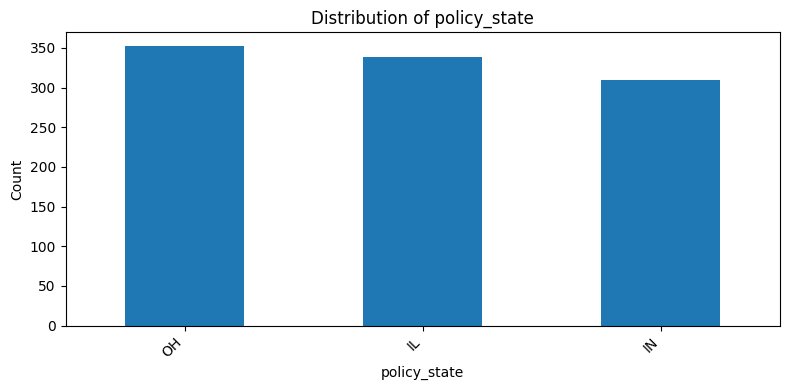

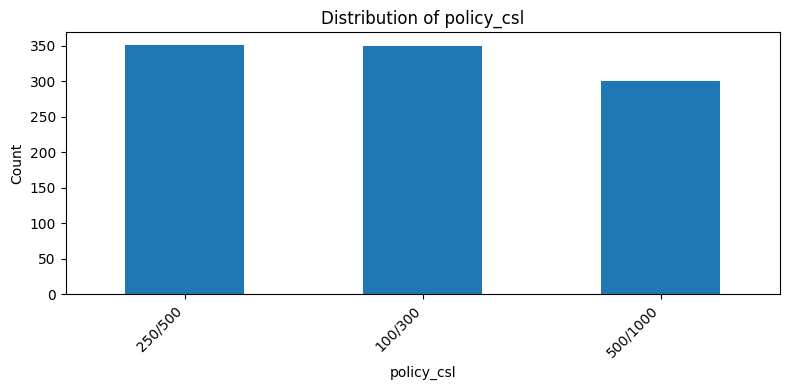

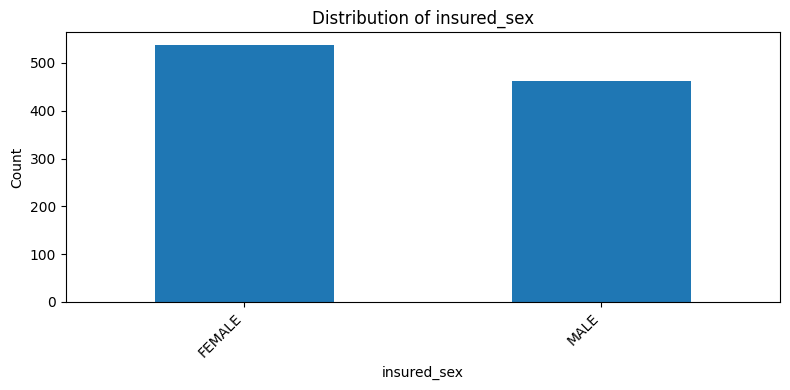

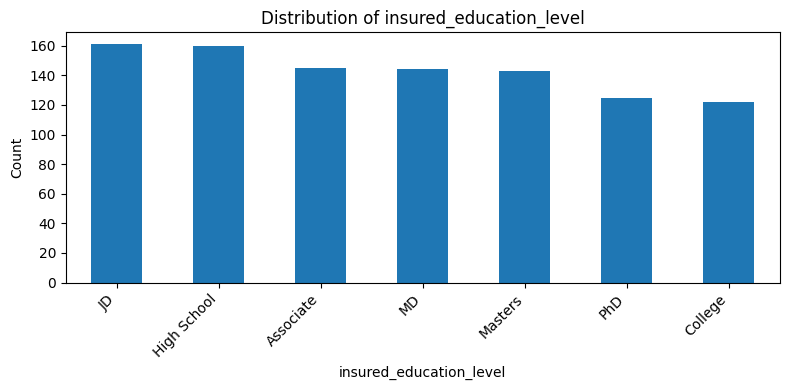

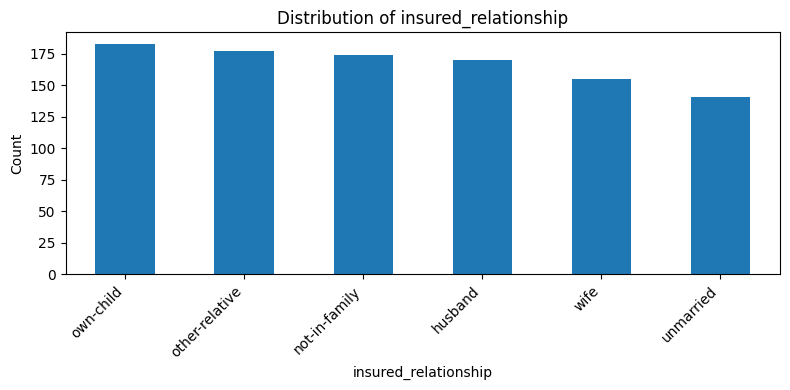

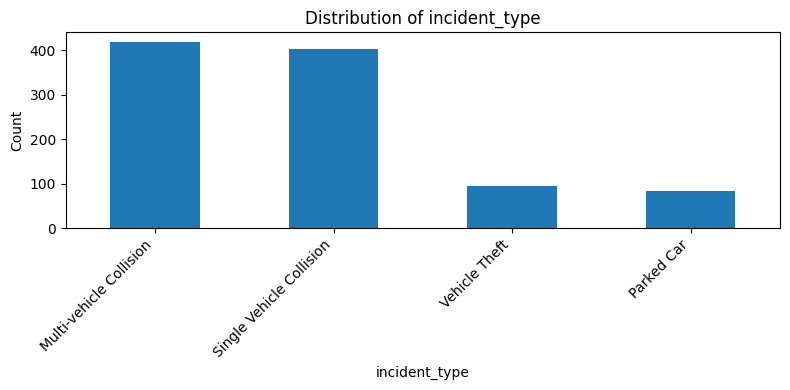

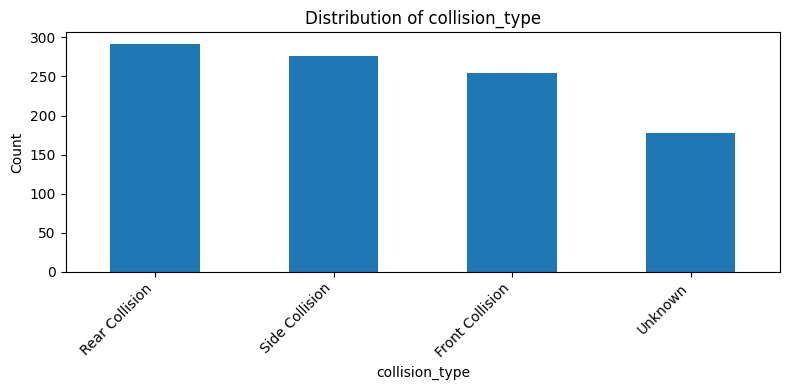

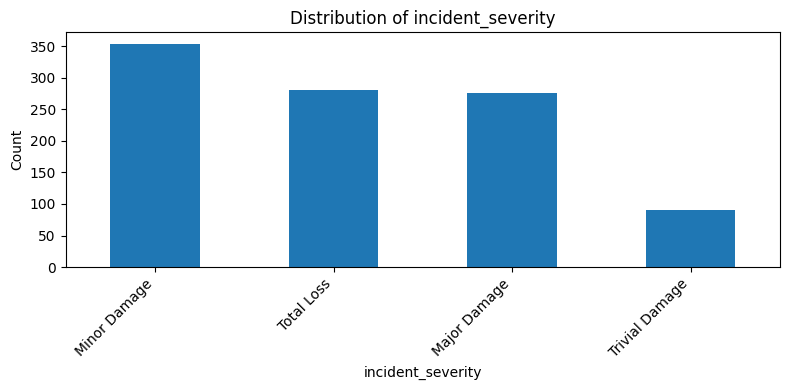

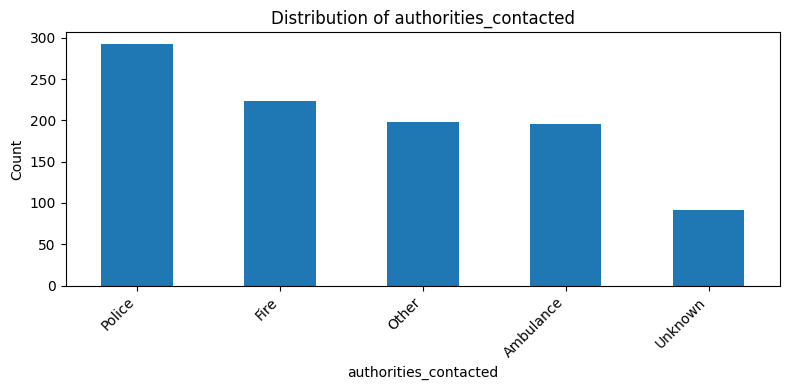

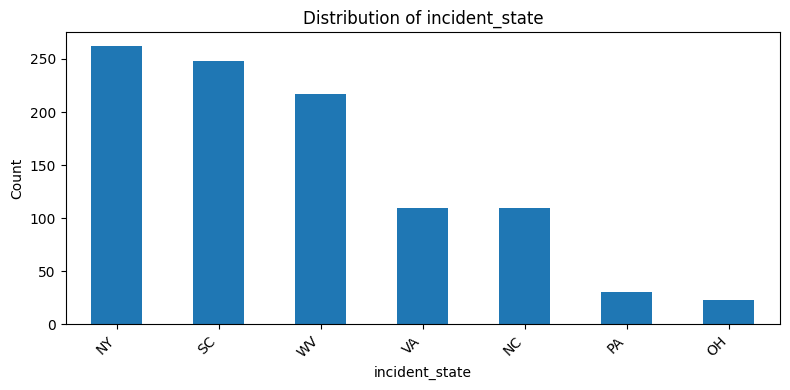

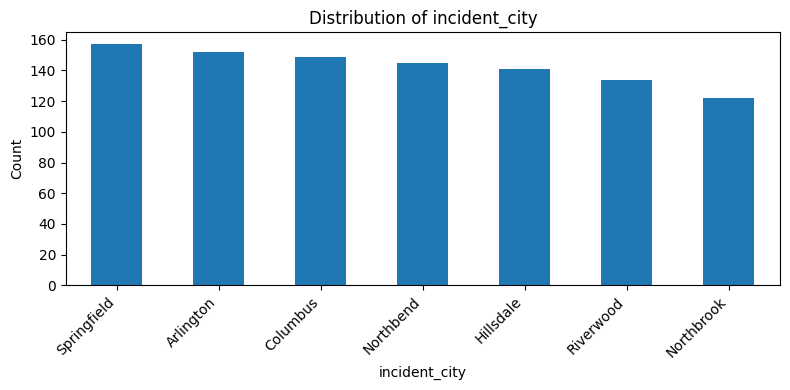

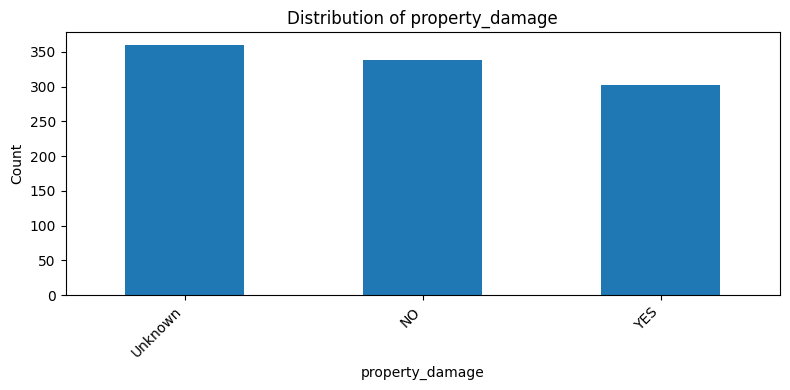

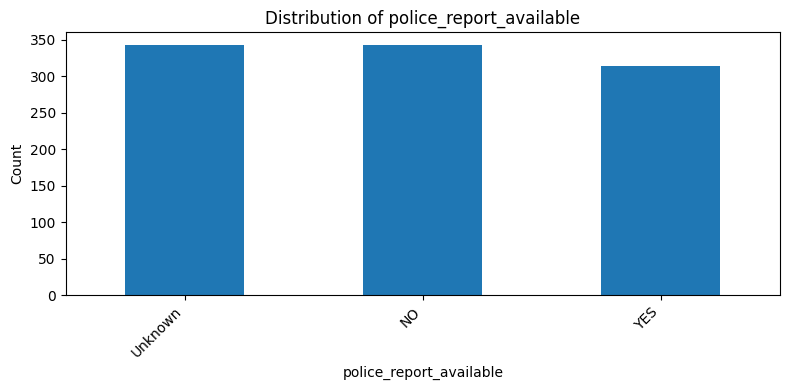

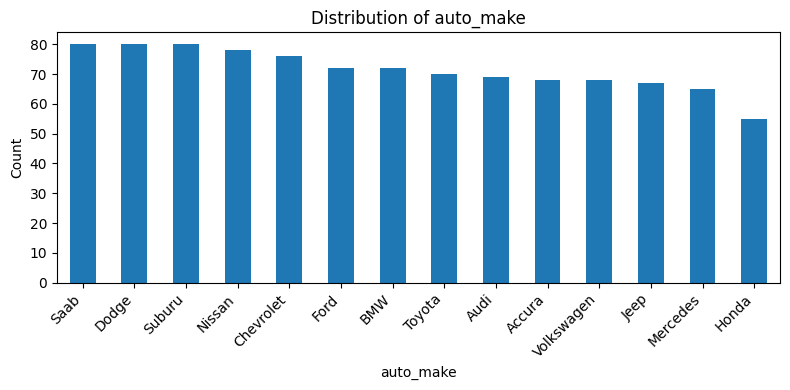

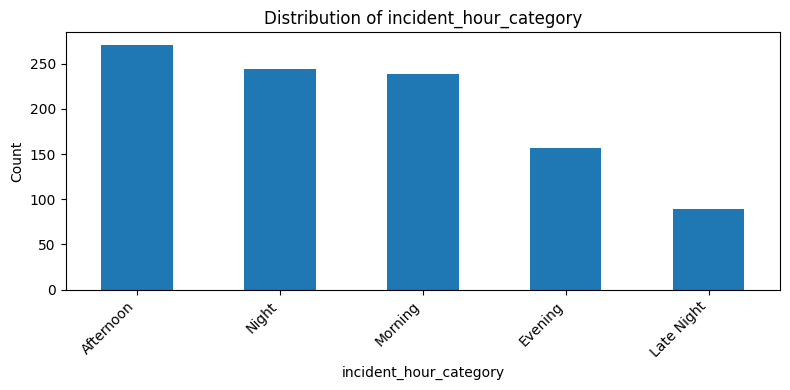

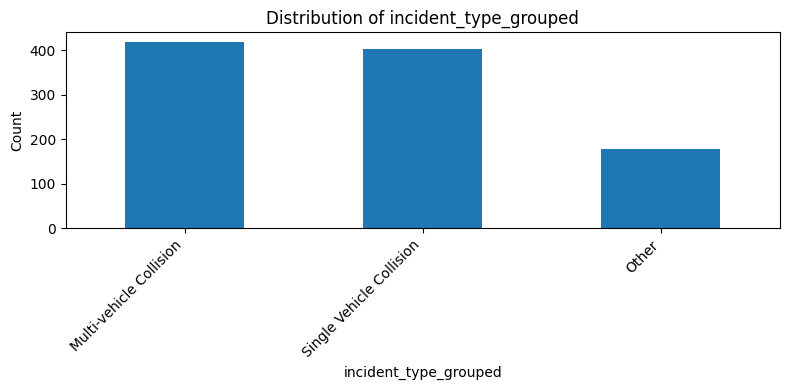

In [14]:
cat_features = dataset.select_dtypes(include=['object', 'category']).columns

# Step 2: Plot distribution of each categorical feature
for col in cat_features:
    plt.figure(figsize=(8, 4))
    dataset[col].value_counts(dropna=False).plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [15]:
cat_features = dataset.select_dtypes(include=['object', 'category']).columns
dataset_encoded = pd.get_dummies(dataset, columns=cat_features)

dataset_encoded[dataset_encoded.select_dtypes(include=['bool']).columns] = dataset_encoded.select_dtypes(include=['bool']).astype(int)

dataset_encoded.head()

,months_as_customer,age,policy_deductable,policy_annual_premium,capital-gains,capital-loss,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,...,auto_make_Toyota,auto_make_Volkswagen,incident_hour_category_Afternoon,incident_hour_category_Evening,incident_hour_category_Late Night,incident_hour_category_Morning,incident_hour_category_Night,incident_type_grouped_Multi-vehicle Collision,incident_type_grouped_Other,incident_type_grouped_Single Vehicle Collision
0,328,48,1000,1406.91,53300,0,1,1,2,71610,...,0,0,0,0,0,0,1,0,0,1
1,228,42,2000,1197.22,0,0,1,0,0,5070,...,0,0,0,0,0,1,0,0,1,0
2,134,29,2000,1413.14,35100,0,3,2,3,34650,...,0,0,0,0,0,1,0,1,0,0
3,256,41,2000,1415.74,48900,-62400,1,1,2,63400,...,0,0,0,0,0,0,1,0,0,1
4,228,44,1000,1583.91,66000,-46000,1,0,1,6500,...,0,0,0,1,0,0,0,0,1,0


In [16]:
dataset_encoded.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 97 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   months_as_customer                              1000 non-null   int64  
 1   age                                             1000 non-null   int64  
 2   policy_deductable                               1000 non-null   int64  
 3   policy_annual_premium                           1000 non-null   float64
 4   capital-gains                                   1000 non-null   int64  
 5   capital-loss                                    1000 non-null   int64  
 6   number_of_vehicles_involved                     1000 non-null   int64  
 7   bodily_injuries                                 1000 non-null   int64  
 8   witnesses                                       1000 non-null   int64  
 9   total_claim_amount                        

In [17]:
dataset_encoded.describe()


,months_as_customer,age,policy_deductable,policy_annual_premium,capital-gains,capital-loss,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,...,auto_make_Toyota,auto_make_Volkswagen,incident_hour_category_Afternoon,incident_hour_category_Evening,incident_hour_category_Late Night,incident_hour_category_Morning,incident_hour_category_Night,incident_type_grouped_Multi-vehicle Collision,incident_type_grouped_Other,incident_type_grouped_Single Vehicle Collision
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,1136.000000,1256.406150,25126.100000,-26793.700000,1.83900,0.992000,1.487000,52761.94000,...,0.070000,0.068000,0.271000,0.157000,0.089000,0.239000,0.244000,0.419000,0.178000,0.403000
std,115.113174,9.140287,611.864673,244.167395,27872.187708,28104.096686,1.01888,0.820127,1.111335,26401.53319,...,0.255275,0.251872,0.444699,0.363983,0.284886,0.426686,0.429708,0.493642,0.382704,0.490746
min,0.000000,19.000000,500.000000,433.330000,0.000000,-111100.000000,1.00000,0.000000,0.000000,100.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,115.750000,32.000000,500.000000,1089.607500,0.000000,-51500.000000,1.00000,0.000000,1.000000,41812.50000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,199.500000,38.000000,1000.000000,1257.200000,0.000000,-23250.000000,1.00000,1.000000,1.000000,58055.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,276.250000,44.000000,2000.000000,1415.695000,51025.000000,0.000000,3.00000,2.000000,2.000000,70592.50000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,479.000000,64.000000,2000.000000,2047.590000,100500.000000,0.000000,4.00000,2.000000,3.000000,114920.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
print(dataset_encoded.isnull().sum()[dataset_encoded.isnull().sum() > 0])

Series([], dtype: int64)


<Figure size 500x400 with 0 Axes>

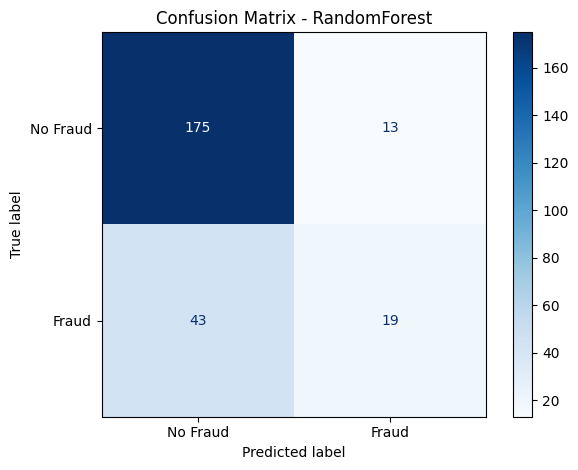

<Figure size 500x400 with 0 Axes>

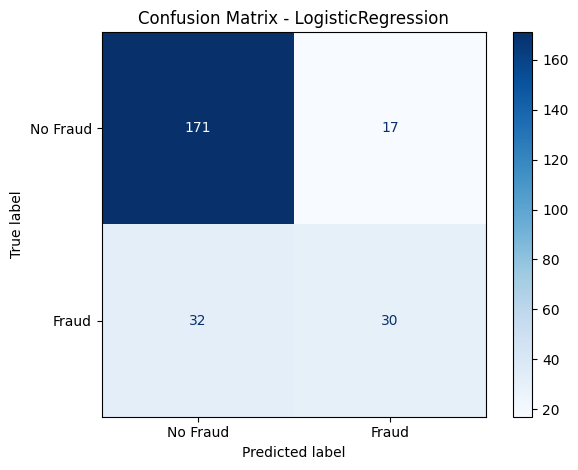

<Figure size 500x400 with 0 Axes>

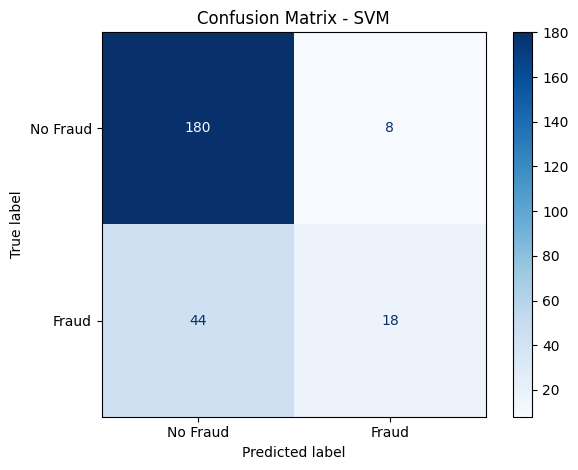

<Figure size 500x400 with 0 Axes>

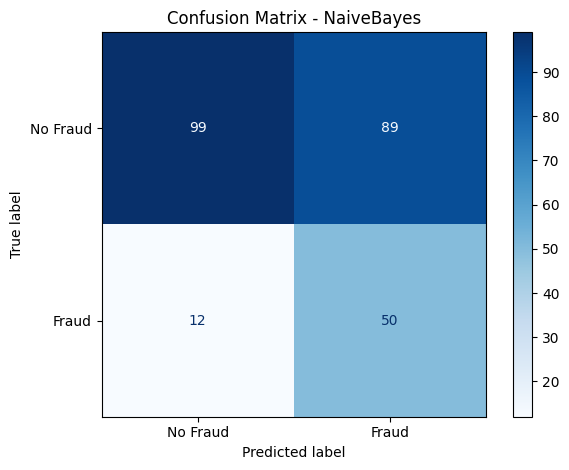

<Figure size 500x400 with 0 Axes>

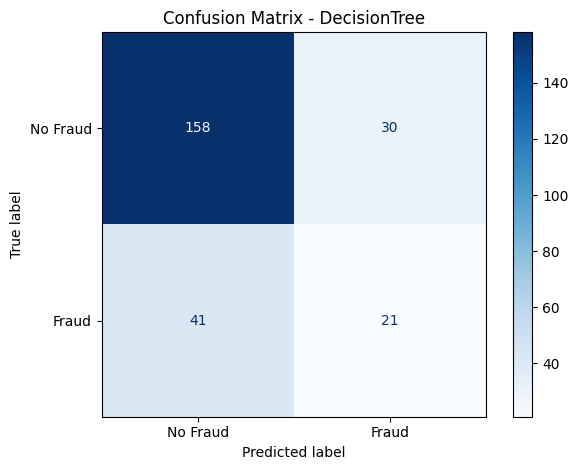

<Figure size 500x400 with 0 Axes>

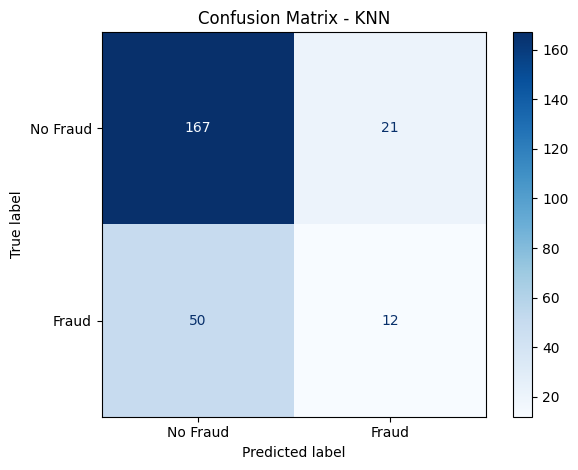

,ROC AUC (CV Mean),ROC AUC (CV Std),ROC AUC (Test Set),Precision,Recall,F1-Score
RandomForest,0.756637,0.061265,0.764885,0.593750,0.306452,0.404255
LogisticRegression,0.753026,0.034054,0.740305,0.638298,0.483871,0.550459
SVM,0.737336,0.037685,0.757593,0.692308,0.290323,0.409091
NaiveBayes,0.717364,0.059616,0.723662,0.359712,0.806452,0.497512
DecisionTree,0.595575,0.059392,0.589568,0.411765,0.338710,0.371681
KNN,0.562497,0.021105,0.613075,0.363636,0.193548,0.252632
BestRandomForest_Tuned,NaN,NaN,0.753775,0.500000,0.032258,0.060606


In [30]:
target_column = 'fraud_reported_int'
# ---------------------------------------------------
X = dataset_encoded.drop(target_column, axis=1)
y = dataset_encoded[target_column]

# Identify numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns

# Separate binary and continuous numeric columns
binary_cols = [col for col in numeric_cols if X[col].dropna().isin([0, 1]).all()]
continuous_cols = [col for col in numeric_cols if col not in binary_cols]

# ---------------------------------------------------
# Step 2: Define preprocessing pipeline
# ---------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), continuous_cols),
        ('passthrough', 'passthrough', binary_cols)
    ]
)

# ---------------------------------------------------
# Step 3: Define models to evaluate
# ---------------------------------------------------
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier() #,     'XGBoost': XGBClassifier(eval_metric='logloss')
}

# ---------------------------------------------------
# Step 4: Evaluate models using pipeline
# ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')
    results[name] = {
        'ROC AUC (CV Mean)': scores.mean(),
        'ROC AUC (CV Std)': scores.std()
    }

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fraud', 'Fraud'])
    plt.figure(figsize=(5, 4))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()
    
    results[name].update({
        'ROC AUC (Test Set)': auc,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score']
    })


# ---------------------------------------------------
# Step 5: Random Forest Hyperparameter Tuning
# ---------------------------------------------------
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

pipe_rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

search = RandomizedSearchCV(pipe_rf, param_distributions=param_dist, n_iter=10,
                            cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
search.fit(X_train, y_train)

best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_proba)

results['BestRandomForest_Tuned'] = {
    'ROC AUC (Test Set)': roc_auc,
    'Precision': report['1']['precision'],
    'Recall': report['1']['recall'],
    'F1-Score': report['1']['f1-score']
}

# ---------------------------------------------------
# Step 6: Display results
# ---------------------------------------------------
results_df = pd.DataFrame(results).T

results_df


In [20]:
from sklearn.model_selection import learning_curve
 

def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    
    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, label='Train AUC')
    plt.plot(train_sizes, test_mean, label='CV AUC')
    plt.xlabel("Training Size")
    plt.ylabel("AUC")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


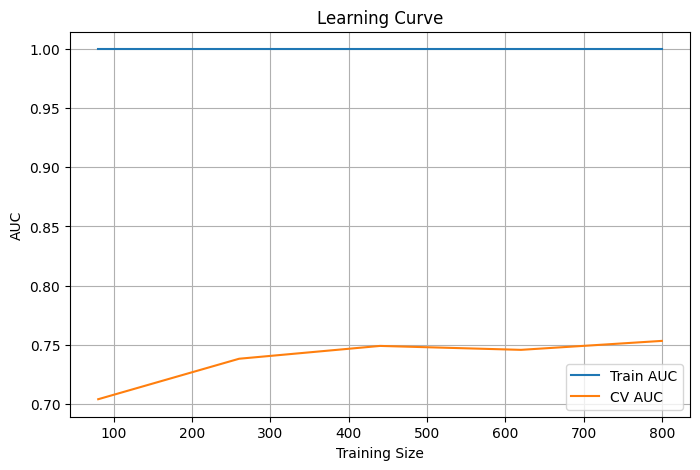

In [21]:
plot_learning_curve(RandomForestClassifier(), X, y)


Best Model Candidates: 
  - RandomForest and SVM are your top performers overall.
  - SVM slightly edges out in ROC AUC, but RandomForest has better F1-score.
  - BestRandomForest_Tuned has slightly lower precision, possibly overfitting recall.





In [28]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Fit model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 20
print(importances_df.head(20).sort_values(by='Importance', ascending=False))

                           Feature  Importance
45  incident_severity_Major Damage    0.112158
11                  property_claim    0.047806
9               total_claim_amount    0.042397
12                   vehicle_claim    0.042281
3            policy_annual_premium    0.042026
10                    injury_claim    0.040682
0               months_as_customer    0.036750
13  days_between_bind_and_incident    0.036116
1                              age    0.031114
46  incident_severity_Minor Damage    0.029082
14                        auto_age    0.029027
4                    capital-gains    0.025706
47    incident_severity_Total Loss    0.023756
5                     capital-loss    0.022527
8                        witnesses    0.015084
7                  bodily_injuries    0.013987
2                policy_deductable    0.010743
58               incident_state_SC    0.009629
91  incident_hour_category_Morning    0.007965
6      number_of_vehicles_involved    0.007175


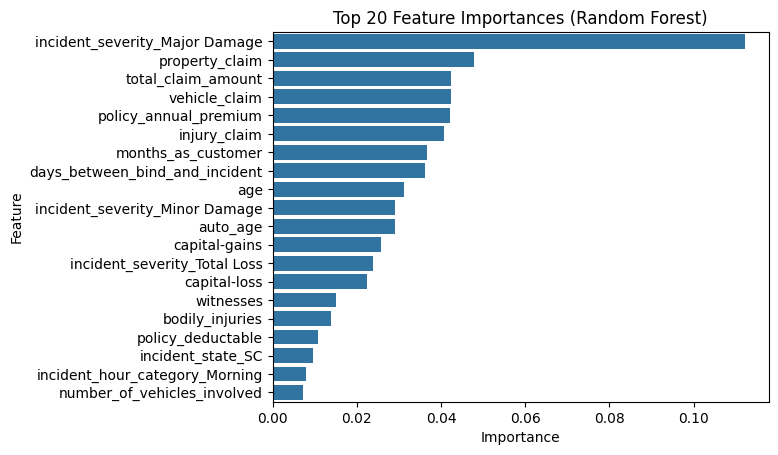

In [29]:
sns.barplot(data=importances_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.show()

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

In [24]:
# No any graph there

![Alt Text](fig75.png)